In [2]:
import os
cwd = os.getcwd()
print(f"Current working directory: {cwd}")

Current working directory: C:\Windows\System32


DICOM to PNG Conversion

In [ ]:
import os
import pandas as pd
import pydicom
from PIL import Image
import numpy as np
from glob import glob

def convert_middle_dicom_to_image(input_dir, output_dir, image_id, group):
    try:
        # Load all DICOM files
        dicoms = [pydicom.dcmread(os.path.join(input_dir, f)) for f in os.listdir(input_dir) if f.endswith('.dcm')]
        
        # Sort DICOMs by Instance Number
        dicoms.sort(key=lambda x: int(x.InstanceNumber))
        
        # Select the middle DICOM file
        if not dicoms:
            print(f"No DICOM files found in {input_dir}")
            return
        middle_index = len(dicoms) // 2
        middle_dicom = dicoms[middle_index]

        # Convert pixel data to a NumPy array
        pixel_array = middle_dicom.pixel_array

        # Normalize and convert to uint8
        pixel_array = ((pixel_array - np.min(pixel_array)) * 255) / (np.max(pixel_array) - np.min(pixel_array))
        pixel_array = pixel_array.astype(np.uint8)

        # Create group-specific output directory
        group_dir = os.path.join(output_dir, group)
        os.makedirs(group_dir, exist_ok=True)

        # Save the image
        image = Image.fromarray(pixel_array)
        output_file = os.path.join(group_dir, f"{image_id}.png")
        image.save(output_file)
        print(f"Image saved successfully: {output_file}")
    except FileNotFoundError:
        print(f"File not found in {input_dir}, check the file path and permissions.")
    except PermissionError:
        print("Permission denied while accessing the files, check the file permissions.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Load metadata
metadata_path = r"C:\Users\dhanu\Downloads\Control_sgittal_mri_image_5_06_2024.csv"  
metadata = pd.read_csv(metadata_path)

# Define output directory
output_dir = cwd

# Process each entry in the metadata
for index, row in metadata.iterrows():
    description = row['Description'].replace(' ', '_')
    # Define the base path up to the description
    base_path = f"C:/Users/dhanu/Downloads/Control_sgittal_mri_image/PPMI/{row['Subject']}/{description}/"

    # Use glob to find the first subdirectory that matches any pattern, assumed to be the next directory
    sub_dirs = glob(os.path.join(base_path, '*/'))  # Gets all direct subdirectories

    if not sub_dirs:
        print(f"No subdirectories found for {base_path}")
        continue

    # Assuming the first subdirectory is the correct one, proceed to find the specific Image Data ID folder
    input_dir = os.path.join(sub_dirs[0], str(row['Image Data ID']))

    convert_middle_dicom_to_image(input_dir, output_dir, str(row['Image Data ID']), row['Group'])

Image Pre-Processing : Trying different parameters and choosing the best.

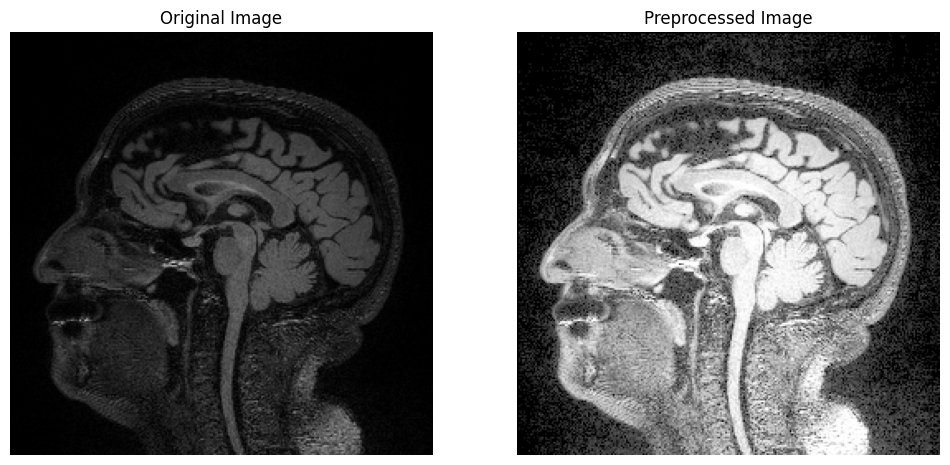

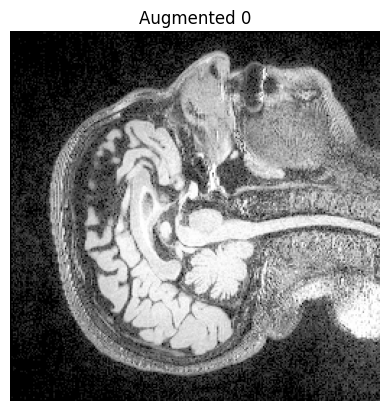

In [12]:
import cv2
import numpy as np
from pywt import wavedec2, waverec2
import albumentations as A
import matplotlib.pyplot as plt

def wavelet_preprocess(image, wavelet='bior3.7', levels=3):
    """
    Apply wavelet-based preprocessing to the input image.
    
    Args:
        image (numpy.ndarray): Input MRI image.
        wavelet (str): Wavelet family to use for DWT.
        levels (int): Number of levels for wavelet decomposition.
        
    Returns:
        numpy.ndarray: Preprocessed image.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply DWT
    coeffs = wavedec2(gray, wavelet, level=levels)
    
    # Reconstruct the image from the wavelet coefficients
    reconstructed = waverec2(coeffs, wavelet)
    
    # Histogram equalization
    preprocessed = cv2.equalizeHist(np.uint8(reconstructed))
    
    return preprocessed

def resize_image(image, target_size):
    """
    Resize the input image while preserving aspect ratio.
    
    Args:
        image (numpy.ndarray): Input image.
        target_size (tuple): Target size (width, height) for resizing.
        
    Returns:
        numpy.ndarray: Resized image.
    """
    height, width = image.shape[:2]
    target_width, target_height = target_size
    
    # Calculate the aspect ratio
    aspect_ratio = width / height
    
    # Calculate the new dimensions while preserving aspect ratio
    new_width = int(target_height * aspect_ratio)
    new_height = int(target_width / aspect_ratio)
    
    # Resize the image
    resized = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    return resized

def augment_images(images, augmentations):
    """
    Apply data augmentation techniques to the input images.
    
    Args:
        images (list): List of input images.
        augmentations (albumentations.Compose): Albumentation's Compose object for data augmentation.
        
    Returns:
        list: List of augmented images.
    """
    augmented_images = []
    for image in images:
        augmented = augmentations(image=image)['image']
        augmented_images.append(augmented)
    
    return augmented_images

# Example usage
image = cv2.imread(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\PD\I1574577.png")

# Wavelet-based preprocessing
preprocessed = wavelet_preprocess(image)

# Plot the original and preprocessed images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(preprocessed, cmap='gray')
ax[1].set_title('Preprocessed Image')
ax[1].axis('off')
plt.show()

# Resize the image
target_size = (256, 256)  # Example target size
resized = resize_image(preprocessed, target_size)

# Data augmentation
augmentations = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2))
])

augmented_images = augment_images([resized], augmentations)

# Display the augmented images
for i, aug_img in enumerate(augmented_images):
    plt.figure()
    plt.imshow(aug_img, cmap='gray')
    plt.title(f'Augmented {i}')
    plt.axis('off')
    plt.show()

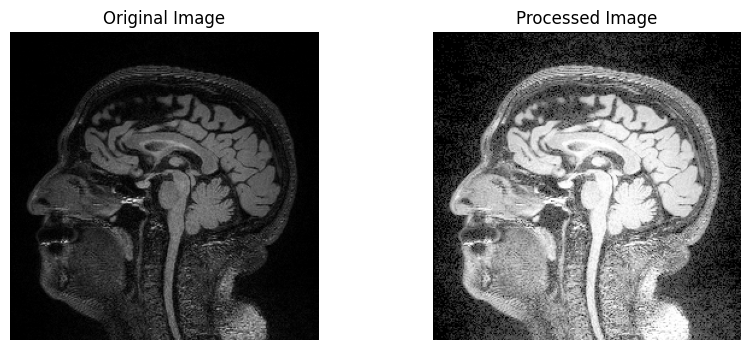

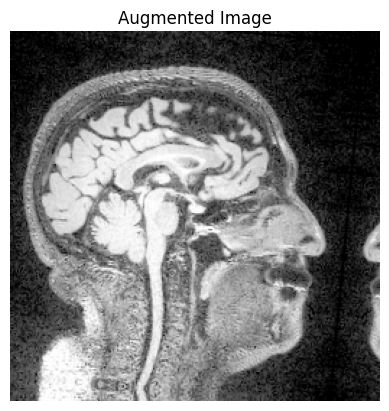

In [14]:
import cv2
import pywt
import numpy as np
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa



def preprocess_image(image_path, target_size=(256, 256)):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Display original image
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Resize the image
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)
    
    # Apply Discrete Wavelet Transform
    coeffs = pywt.dwt2(image, 'bior1.3')
    LL, (LH, HL, HH) = coeffs
    
    # Perform Inverse DWT
    reconstructed_image = pywt.idwt2(coeffs, 'bior1.3')
    
    # Histogram Equalization
    equalized_image = cv2.equalizeHist(reconstructed_image.astype(np.uint8))
    
    # Display processed image
    plt.subplot(1, 2, 2)
    plt.imshow(equalized_image, cmap='gray')
    plt.title('Processed Image')
    plt.axis('off')
    
    plt.show()
    
    return equalized_image

def augment_image(image, padding=50):
    # Add padding
    image_padded = cv2.copyMakeBorder(image, top=padding, bottom=padding, left=padding, right=padding, borderType=cv2.BORDER_REFLECT)
    
    # Define the augmentation sequence with adjusted transformations and better handling for boundaries
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flips
        iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},  # scaling
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},  # translation
            rotate=(-15, 15),  # rotation
            mode='reflect'  # reflect mode to handle borders during transformations
        )
    ])
    
    # Apply augmentation
    image_augmented = seq(image=image_padded)
    
    # Optionally crop back to original size to remove added padding
    height, width = image.shape
    image_augmented = image_augmented[padding:padding+height, padding:padding+width]
    
    return image_augmented


# Example usage
input_image_path = r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\PD\I1574577.png" 
processed_image = preprocess_image(input_image_path)

# You can also display the augmented image by uncommenting the following lines:
augmented_image = augment_image(processed_image)
plt.figure()
plt.imshow(augmented_image, cmap='gray')
plt.title('Augmented Image')
plt.axis('off')
plt.show()


Saving the Pre-processed Images as Numpy arrays.

In [15]:
import os
import cv2
import numpy as np
from pywt import wavedec2, waverec2
from sklearn.model_selection import train_test_split
import albumentations as A
import pickle

In [15]:
import os
import cv2
import numpy as np
from pywt import wavedec2, waverec2
from sklearn.model_selection import train_test_split
import albumentations as A
import pickle

def wavelet_preprocess(image, wavelet='bior3.7', levels=3):
    """
    Apply wavelet-based preprocessing to the input image.
    
    Args:
        image (numpy.ndarray): Input MRI image.
        wavelet (str): Wavelet family to use for DWT.
        levels (int): Number of levels for wavelet decomposition.
        
    Returns:
        numpy.ndarray: Preprocessed image.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply DWT
    coeffs = wavedec2(gray, wavelet, level=levels)
    
    # Reconstruct the image from the wavelet coefficients
    reconstructed = waverec2(coeffs, wavelet)
    
    # Histogram equalization
    preprocessed = cv2.equalizeHist(np.uint8(reconstructed))
    
    return preprocessed

def resize_image(image, target_size):
    """
    Resize the input image to a fixed size by padding or cropping.
    """
    height, width = image.shape[:2]
    target_width, target_height = target_size

    # Calculate the aspect ratio
    aspect_ratio = width / height

    # Calculate the new dimensions while preserving aspect ratio
    new_width = target_width
    new_height = int(target_width / aspect_ratio)

    # Resize the image
    resized = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Determine the number of channels
    if len(resized.shape) == 2:
        channels = 1
        resized = np.expand_dims(resized, axis=2)
    else:
        channels = resized.shape[2]

    # Create a new image with the target size and fill it with black
    padded = np.zeros((target_height, target_width, channels), dtype=np.uint8)

    # Calculate the starting point for cropping or padding
    start_y = (target_height - new_height) // 2
    start_x = 0

    # Crop or pad the image
    if new_height > target_height:
        # Crop the image
        padded = resized[0:target_height, :]
    else:
        # Pad the image
        padded[start_y:start_y+new_height, :] = resized

    return padded

def augment_images(images, labels, augmentations):
    """
    Apply data augmentation techniques to the input images and labels.
    """
    augmented_images = []
    augmented_labels = []
    for image, label in zip(images, labels):
        augmented = augmentations(image=image)['image']
        augmented_images.append(augmented)
        augmented_labels.append(label)
    
    return augmented_images, augmented_labels

def load_images(data_dir, categories):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        for filename in os.listdir(category_path):
            image_path = os.path.join(category_path, filename)
            image = cv2.imread(image_path)
            if image is not None:
                images.append(image)
                labels.append(categories.index(category))
    
    return images, labels

def preprocess_and_save(data_dir, categories, target_size, output_file):
    images, labels = load_images(data_dir, categories)

    # Preprocess images
    preprocessed_images = []
    for image in images:
        preprocessed = wavelet_preprocess(image)
        resized = resize_image(preprocessed, target_size)
        preprocessed_images.append(resized)
        
    for i, image in enumerate(preprocessed_images):
        print(f"Preprocessed image {i+1} shape: {image.shape}")
        
    # Data augmentation
    augmentations = A.Compose([
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
    ])


    augmented_images, augmented_labels = augment_images(preprocessed_images, labels, augmentations)
    preprocessed_images.extend(augmented_images)
    labels.extend(augmented_labels)


    # Split data into train, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, labels, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Convert to NumPy arrays
    X_train = np.array(X_train)
    X_valid = np.array(X_valid)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_valid = np.array(y_valid)
    y_test = np.array(y_test)
    print(X_train)
    # Save data as NumPy arrays or pickle files
    np.save(f"{output_file}_X_train.npy", X_train)
    np.save(f"{output_file}_y_train.npy", y_train)
    np.save(f"{output_file}_X_valid.npy", X_valid)
    np.save(f"{output_file}_y_valid.npy", y_valid)
    np.save(f"{output_file}_X_test.npy", X_test)
    np.save(f"{output_file}_y_test.npy", y_test)

    # Alternatively, save data as pickle files
    with open(f"{output_file}_data.pkl", "wb") as f:
         pickle.dump((X_train, y_train, X_valid, y_valid, X_test, y_test), f)

# Example usage
data_dir = r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification"
categories = ["PD", "Control"]
target_size = (256, 256)
output_file = cwd

preprocess_and_save(data_dir, categories, target_size, output_file)

Preprocessed image 1 shape: (256, 256, 1)
Preprocessed image 2 shape: (256, 256, 1)
Preprocessed image 3 shape: (256, 256, 1)
Preprocessed image 4 shape: (256, 256, 1)
Preprocessed image 5 shape: (256, 256, 1)
Preprocessed image 6 shape: (256, 256, 1)
Preprocessed image 7 shape: (256, 256, 1)
Preprocessed image 8 shape: (256, 256, 1)
Preprocessed image 9 shape: (256, 256, 1)
Preprocessed image 10 shape: (256, 256, 1)
Preprocessed image 11 shape: (256, 256, 1)
Preprocessed image 12 shape: (256, 256, 1)
Preprocessed image 13 shape: (256, 256, 1)
Preprocessed image 14 shape: (256, 256, 1)
Preprocessed image 15 shape: (256, 256, 1)
Preprocessed image 16 shape: (256, 256, 1)
Preprocessed image 17 shape: (256, 256, 1)
Preprocessed image 18 shape: (256, 256, 1)
Preprocessed image 19 shape: (256, 256, 1)
Preprocessed image 20 shape: (256, 256, 1)
Preprocessed image 21 shape: (256, 256, 1)
Preprocessed image 22 shape: (256, 256, 1)
Preprocessed image 23 shape: (256, 256, 1)
Preprocessed image 2

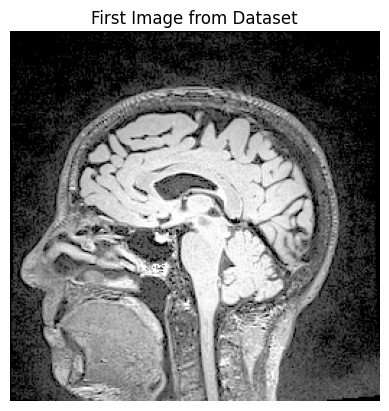

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Load the image data from the saved NumPy file
images = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\System32_X_train.npy")

# Display the first image in the array
plt.imshow(images[836], cmap='gray')  # Use cmap='gray' for grayscale images
plt.title('First Image from Dataset')
plt.axis('off')  # Hide the axis
plt.show()

Feature Extraction Step: Trying different Techniques and hyperparameters to chooose the best with XGBoost

In [41]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from skimage.color import rgb2gray

def extract_intensity_features(image):
    """
    Extract intensity-based features from a single image.
    """
    mean_intensity = np.mean(image)
    median_intensity = np.median(image)
    std_intensity = np.std(image)
    min_intensity = np.min(image)
    max_intensity = np.max(image)
    
    return [mean_intensity, median_intensity, std_intensity, min_intensity, max_intensity]

def extract_texture_features(image, distances=[1], angles=[0], levels=256):
    """
    Extract texture-based features from a single image using Gray-Level Co-occurrence Matrix (GLCM).
    """
    if image.ndim == 3 and image.shape[2] == 1:
        image = np.squeeze(image, axis=2)
        
    texture_features = []
    for distance in distances:
        for angle in angles:
            glcm = graycomatrix(image, [distance], [angle], levels=levels, normed=True)
            contrast = graycoprops(glcm, 'contrast')[0, 0]
            dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
            homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
            energy = graycoprops(glcm, 'energy')[0, 0]
            correlation = graycoprops(glcm, 'correlation')[0, 0]
            texture_features.extend([contrast, dissimilarity, homogeneity, energy, correlation])
    
    return texture_features

def extract_features(images):
    """
    Extract intensity-based and texture-based features from a list of images.
    """
    features = []
    for image in images:
        intensity_features = extract_intensity_features(image)
        texture_features = extract_texture_features(image)
        features.append(intensity_features + texture_features)
    
    return np.array(features)

def feature_selection(X, y):
    """
    Perform feature selection using XGBoost.
    """
    xgb_model = XGBClassifier(n_jobs=-1, random_state=42)
    xgb_model.fit(X, y)
    feature_importances = xgb_model.feature_importances_
    important_features = np.where(feature_importances > np.percentile(feature_importances, 75))[0]
    X_selected = X[:, important_features]
    
    return X_selected, important_features


def hyperparameter_tuning(X, y):
    """
    Perform hyperparameter tuning using GridSearchCV.
    """
    param_grid = {
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1]
    }
    
    xgb_model = XGBClassifier(n_jobs=-1, random_state=42)
    grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    
    best_model = grid_search.best_estimator_
    
    return best_model

# Load your preprocessed images and labels from NumPy arrays or pickle files
X_train = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\System32_X_train.npy")
y_train = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\System32_y_train.npy")
X_valid = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\System32_X_valid.npy")
y_valid = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\System32_y_valid.npy")
X_test = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\System32_X_test.npy")
y_test = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\System32_y_test.npy")

# Extract features from the training set
X_train_features = extract_features(X_train)

# Perform feature selection
X_train_selected, selected_indices = feature_selection(X_train_features, y_train)

# Perform hyperparameter tuning
best_model = hyperparameter_tuning(X_train_selected, y_train)

# Extract features from the validation and test sets using the selected features
X_valid_features = extract_features(X_valid)[:, selected_indices]
X_test_features = extract_features(X_test)[:, selected_indices]

# Evaluate the best model on the validation and test sets
valid_accuracy = best_model.score(X_valid_features, y_valid)
test_accuracy = best_model.score(X_test_features, y_test)

print(f"Validation accuracy: {valid_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Validation accuracy: 0.7391
Test accuracy: 0.6957


In [23]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
import pickle

def extract_intensity_features(image):
    """
    Extract intensity-based features from a single image.
    """
    mean_intensity = np.mean(image)
    median_intensity = np.median(image)
    std_intensity = np.std(image)
    min_intensity = np.min(image)
    max_intensity = np.max(image)
    
    return [mean_intensity, median_intensity, std_intensity, min_intensity, max_intensity]

def extract_texture_features(image, distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256):
    """
    Extract texture-based features from a single image using Gray-Level Co-occurrence Matrix (GLCM).
    """
    # Ensure image is 2D
    if image.ndim == 3 and image.shape[2] == 1:
        image = np.squeeze(image, axis=2)

    texture_features = []
    for distance in distances:
        for angle in angles:
            glcm = graycomatrix(image, [distance], [angle], levels=levels, symmetric=True, normed=True)
            for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
                texture_features.append(graycoprops(glcm, prop)[0, 0])
    
    return texture_features


def extract_lbp_features(image, P=8, R=1, method='uniform'):
    """
    Extract Local Binary Pattern features from a single image.
    """
    if image.ndim == 3 and image.shape[2] == 1:
        image = np.squeeze(image, axis=2)
    
    lbp = local_binary_pattern(image, P, R, method)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    
    return hist.tolist()


def extract_features(images):
    """
    Extract intensity-based, texture-based, and LBP-based features from a list of images.
    """
    features = []
    for image in images:
        intensity_features = extract_intensity_features(image)
        texture_features = extract_texture_features(image)
        lbp_features = extract_lbp_features(image)
        combined_features = intensity_features + texture_features + lbp_features
        features.append(combined_features)
    
    return np.array(features)


def feature_selection(X, y):
    """
    Perform feature selection using XGBoost.
    """
    xgb_model = XGBClassifier(n_jobs=-1, random_state=42)
    xgb_model.fit(X, y)
    feature_importances = xgb_model.feature_importances_
    important_features = np.where(feature_importances > np.percentile(feature_importances, 75))[0]
    X_selected = X[:, important_features]
    
    return X_selected, important_features


def hyperparameter_tuning(X, y):
    """
    Perform hyperparameter tuning using GridSearchCV.
    """
    param_grid = {
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.001]
    }
    
    xgb_model = XGBClassifier(n_jobs=-1, random_state=42)
    grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    with open('grid_xgb.pkl', 'wb') as file:
        pickle.dump(grid_search, file)
    best_model = grid_search.best_estimator_
    
    return best_model

# Load your preprocessed images and labels from NumPy arrays or pickle files
X_train = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\X_train.npy")
y_train = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\y_train.npy")
X_valid = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\X_valid.npy")
y_valid = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\y_valid.npy")
X_test = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\X_test.npy")
y_test = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\y_test.npy")

# Extract features from the training set
X_train_features = extract_features(X_train)

# Perform feature selection
X_train_selected, selected_indices = feature_selection(X_train_features, y_train)

# Perform hyperparameter tuning
best_model = hyperparameter_tuning(X_train_selected, y_train)

# Extract features from the validation and test sets using the selected features
X_valid_features = extract_features(X_valid)[:, selected_indices]
X_test_features = extract_features(X_test)[:, selected_indices]

# Evaluate the best model on the validation and test sets
valid_accuracy = best_model.score(X_valid_features, y_valid)
test_accuracy = best_model.score(X_test_features, y_test)

print(f"Validation accuracy: {valid_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

output_file = cwd

# Save data as NumPy arrays or pickle files
try:
    np.save("X_train_features.npy", X_train_selected)
    np.save("X_valid_features.npy", X_valid_features)
    np.save("X_test_features.npy", X_test_features)
    # Save the model to disk
    filename = 'XGboost_feature_selection.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(best_model, file)
except Exception as e:
    # If an exception occurs, print the error message
    print(f"An error occurred while saving the file: {e}")
else:
    current_dir = os.getcwd()
    print(f"Array saved successfully at: {current_dir}")
    print("saved")


Validation accuracy: 0.7971
Test accuracy: 0.8029
Array saved successfully at: C:\Windows\System32
saved


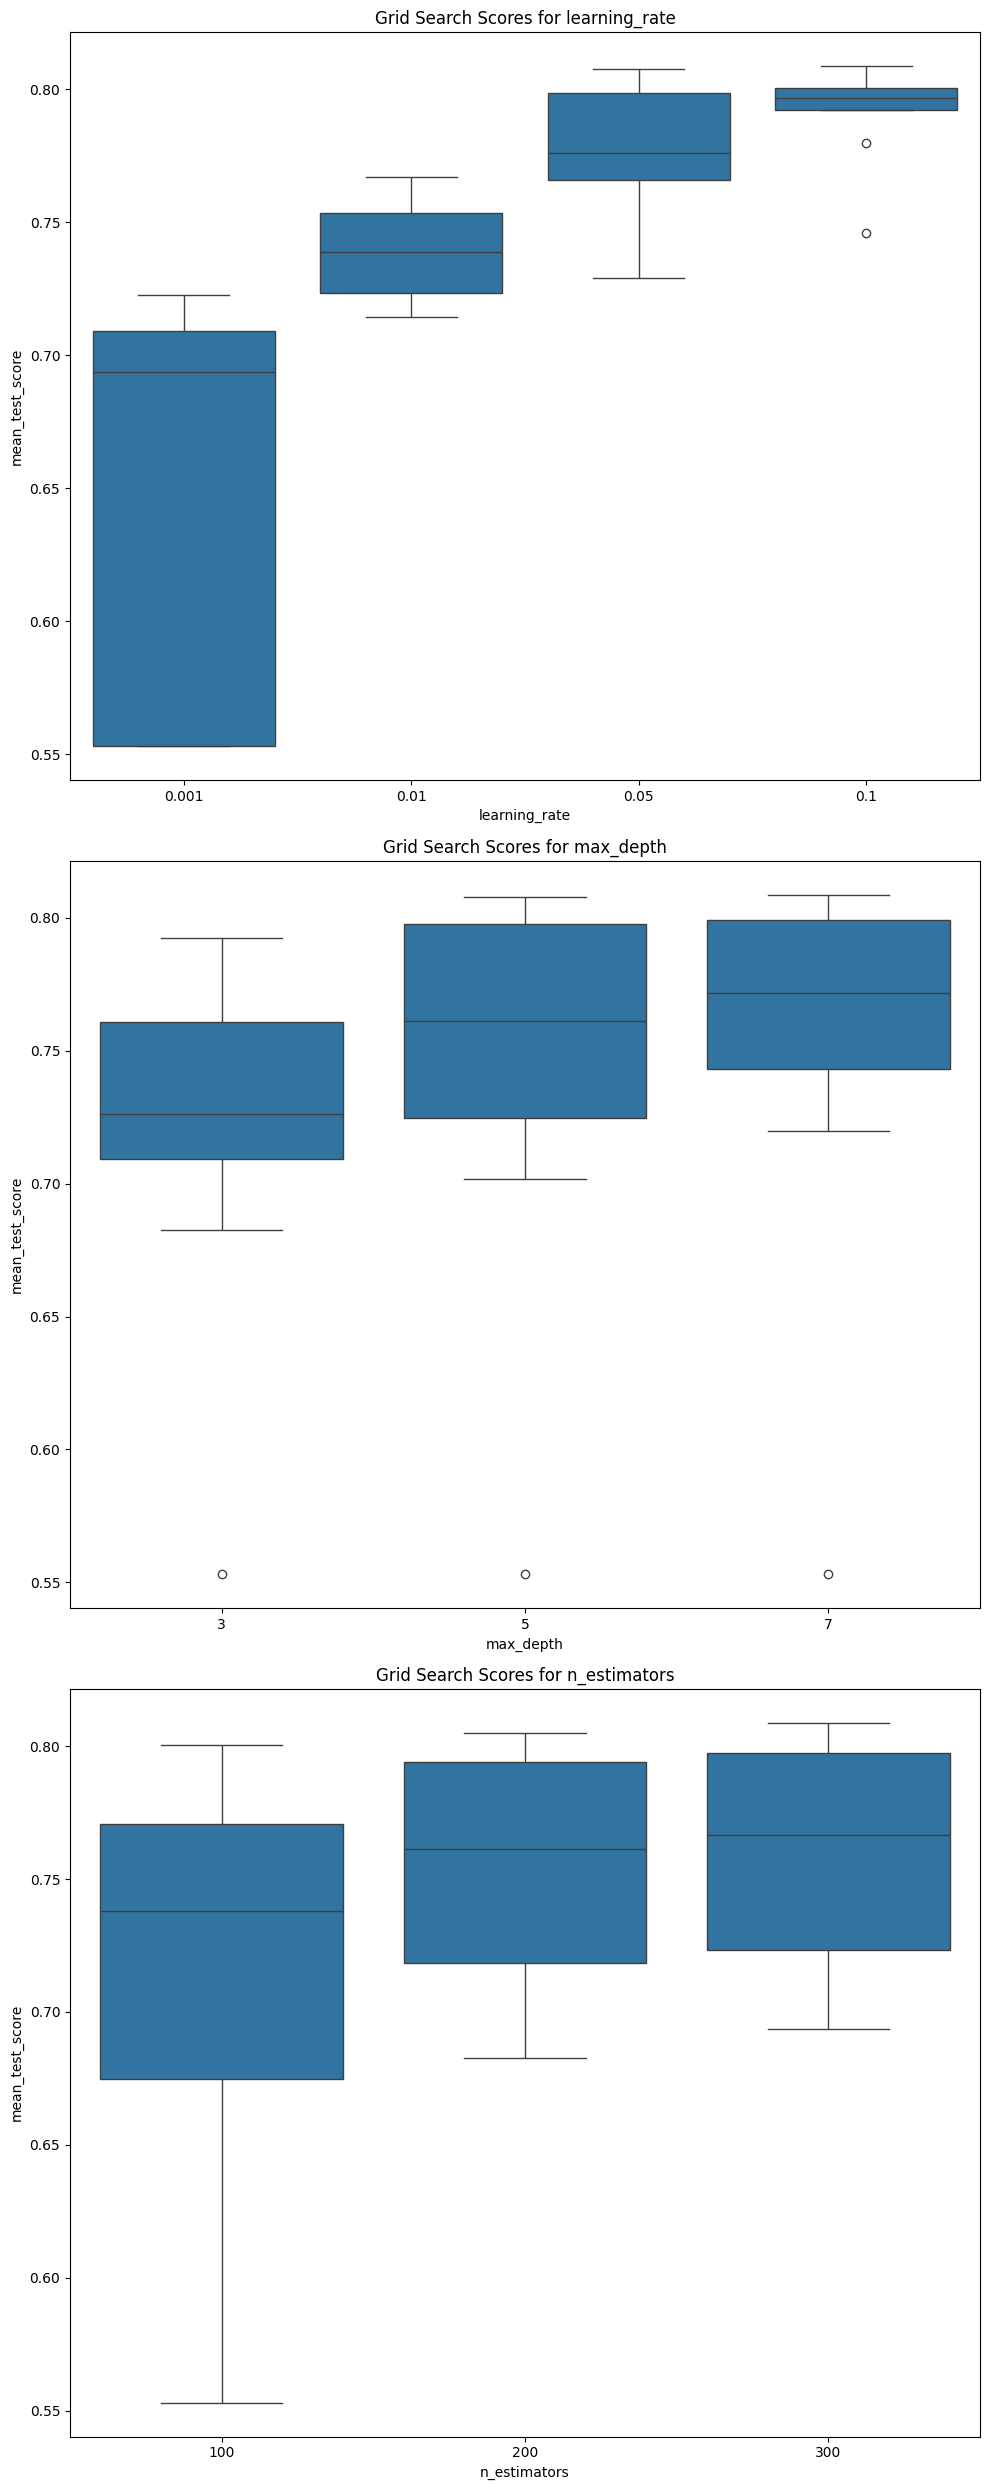

In [25]:
# Grid Search Results (example with grid_xgb, replace with your actual grid search object if different)
def plot_grid_search_results(grid_search):
    param_grid = list(grid_search.cv_results_['params'][0].keys())
    scores = grid_search.cv_results_['mean_test_score']
    
    results = pd.DataFrame(grid_search.cv_results_['params'])
    results['mean_test_score'] = scores
    
    fig, axs = plt.subplots(len(param_grid), 1, figsize=(10, 25))
    
    for i, param in enumerate(param_grid):
        sns.boxplot(x=param, y='mean_test_score', data=results, ax=axs[i])
        axs[i].set_title(f'Grid Search Scores for {param}')
    
    plt.tight_layout()
    plt.show()

# Assuming grid_xgb is still in scope or reload if necessary
grid_xgb = pickle.load(open('grid_xgb.pkl', 'rb'))  # If you saved the grid search results
plot_grid_search_results(grid_xgb)

In [11]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern

def extract_intensity_features(image):
    """
    Extract intensity-based features from a single image.
    """
    mean_intensity = np.mean(image)
    median_intensity = np.median(image)
    std_intensity = np.std(image)
    min_intensity = np.min(image)
    max_intensity = np.max(image)
    
    return [mean_intensity, median_intensity, std_intensity, min_intensity, max_intensity]

def extract_texture_features(image, distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256):
    """
    Extract texture-based features from a single image using Gray-Level Co-occurrence Matrix (GLCM).
    """
    # Ensure image is 2D
    if image.ndim == 3 and image.shape[2] == 1:
        image = np.squeeze(image, axis=2)

    texture_features = []
    for distance in distances:
        for angle in angles:
            glcm = graycomatrix(image, [distance], [angle], levels=levels, symmetric=True, normed=True)
            for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
                texture_features.append(graycoprops(glcm, prop)[0, 0])
    
    return texture_features


def extract_lbp_features(image, P=8, R=1, method='uniform'):
    """
    Extract Local Binary Pattern features from a single image.
    """
    if image.ndim == 3 and image.shape[2] == 1:
        image = np.squeeze(image, axis=2)
    
    lbp = local_binary_pattern(image, P, R, method)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    
    return hist.tolist()


def extract_features(images):
    """
    Extract intensity-based, texture-based, and LBP-based features from a list of images.
    """
    features = []
    for image in images:
        intensity_features = extract_intensity_features(image)
        texture_features = extract_texture_features(image)
        lbp_features = extract_lbp_features(image)
        combined_features = intensity_features + texture_features + lbp_features
        features.append(combined_features)
    
    return np.array(features)


def feature_selection(X, y):
    """
    Perform feature selection using XGBoost.
    """
    xgb_model = XGBClassifier(n_jobs=-1, random_state=42)
    xgb_model.fit(X, y)
    feature_importances = xgb_model.feature_importances_
    important_features = np.where(feature_importances > np.percentile(feature_importances, 75))[0]
    X_selected = X[:, important_features]
    
    return X_selected, important_features


def hyperparameter_tuning(X, y):
    """
    Perform hyperparameter tuning using GridSearchCV.
    """
    param_grid = {
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.001]
    }
    
    xgb_model = XGBClassifier(n_jobs=-1, random_state=42)
    grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    
    best_model = grid_search.best_estimator_
    
    return best_model

# Load your preprocessed images and labels from NumPy arrays or pickle files
X_train = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\X_train.npy")
y_train = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\y_train.npy")
X_valid = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\X_valid.npy")
y_valid = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\y_valid.npy")
X_test = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\X_test.npy")
y_test = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\y_test.npy")

# Extract features from the training set
X_train_features = extract_features(X_train)

# Perform feature selection
X_train_selected, selected_indices = feature_selection(X_train_features, y_train)



output_file = cwd

np.save('imp_features.npy', selected_indices)

# Or save selected indices as a Python list using pickle
with open('imp_features.pkl', 'wb') as f:
    pickle.dump(selected_indices.tolist(), f)


Defining Model, parameters and Ensembel model

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

X_train = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\X_train_features.npy")
y_train = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\y_train.npy")
X_valid = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\X_valid_features.npy")
y_valid = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\y_valid.npy")
X_test = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\X_test_features.npy")
y_test = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\y_test.npy")


In [13]:
# Define the parameter grid based on the tables you provided
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 1.5]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Initialize the classifiers
xgb = XGBClassifier(n_jobs=-1, random_state=42)
rf = RandomForestClassifier()
svm = SVC(probability=True)


In [ ]:
Model Training

In [14]:
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1, verbose=10)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=10)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1, verbose=10)

# Fit the grids
grid_xgb.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)
grid_svm.fit(X_train, y_train)

# Best models
best_xgb = grid_xgb.best_estimator_
best_rf = grid_rf.best_estimator_
best_svm = grid_svm.best_estimator_


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [15]:
# Define the stacking ensemble
stack = StackingClassifier(estimators=[
    ('xgb', best_xgb),
    ('rf', best_rf),
    ('svm', best_svm)
], final_estimator=RandomForestClassifier(n_estimators=100, random_state=42))

# Train the stacking classifier
stack.fit(X_train, y_train)


StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=-1,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=20)),
                               ('svm', SVC(C=1, gamma=0.1, probability=True))],
                   final_estimator=RandomForestClassifier(random_state=42))

In [ ]:
MOdel Testing and Graphs

In [16]:
import pickle

# Save the model to disk
filename = 'finalized_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(stack, file)

# Load the model from disk
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Evaluate loaded model
y_pred_loaded = loaded_model.predict(X_test_features)
print(f'Test Accuracy of loaded model: {accuracy_score(y_test, y_pred_loaded):.4f}')


Test Accuracy of loaded model: 0.7826


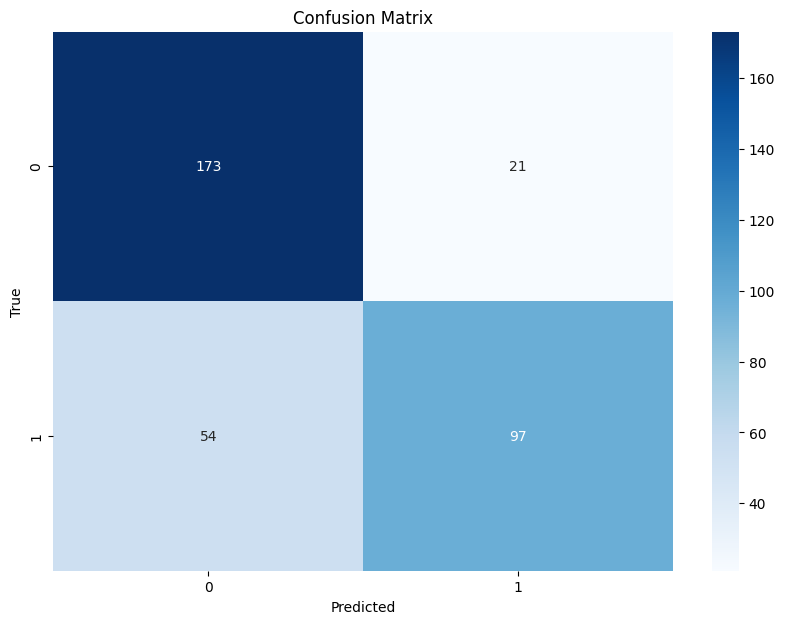

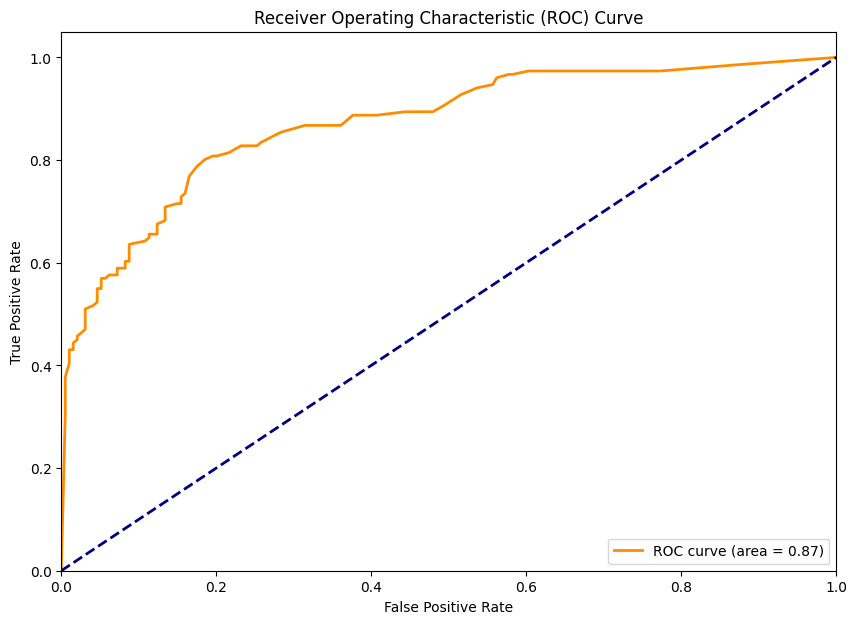

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import learning_curve
import pickle

# Load the model from disk
filename = 'finalized_model.pkl'
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Load your data
X_test = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\X_test_features.npy")
y_test = np.load(r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Pre-process files\y_test.npy")

# Predict using the loaded model
y_pred_loaded = loaded_model.predict(X_test)

# Feature Importance Plot (example using an XGBoost model, replace with your actual model if different)
def plot_feature_importance(model, features):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title("Feature Importances")
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
        plt.show()

# Assuming you have feature names or indices stored in `selected_indices`
selected_indices = np.load('imp_features.npy')  # Load the indices of the selected features
plot_feature_importance(loaded_model, selected_indices)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred_loaded)

# ROC Curve
def plot_roc_curve(model, X_test, y_test):
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(loaded_model, X_test, y_test)


In [27]:
import os
import cv2
from pywt import wavedec2, waverec2
import numpy as np

def wavelet_preprocess(image, wavelet='bior3.7', levels=3):
    if image.ndim == 3 and image.shape[2] == 3:
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        # Assume image is already grayscale
        gray = image
    
    # Apply DWT
    coeffs = wavedec2(gray, wavelet, level=levels)
    
    # Reconstruct the image from the wavelet coefficients
    reconstructed = waverec2(coeffs, wavelet)
    
    # Histogram equalization
    preprocessed = cv2.equalizeHist(np.uint8(reconstructed))
    
    return preprocessed

def resize_image(image, target_size):
    """
    Resize the input image to a fixed size by padding or cropping.
    """
    height, width = image.shape[:2]
    target_width, target_height = target_size

    # Calculate the aspect ratio
    aspect_ratio = width / height

    # Calculate the new dimensions while preserving aspect ratio
    new_width = target_width
    new_height = int(target_width / aspect_ratio)

    # Resize the image
    resized = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Determine the number of channels
    if len(resized.shape) == 2:
        channels = 1
        resized = np.expand_dims(resized, axis=2)
    else:
        channels = resized.shape[2]

    # Create a new image with the target size and fill it with black
    padded = np.zeros((target_height, target_width, channels), dtype=np.uint8)

    # Calculate the starting point for cropping or padding
    start_y = (target_height - new_height) // 2
    start_x = 0

    # Crop or pad the image
    if new_height > target_height:
        # Crop the image
        padded = resized[0:target_height, :]
    else:
        # Pad the image
        padded[start_y:start_y+new_height, :] = resized

    return padded


def preprocess(image_path, target_size):
    image = cv2.imread(image_path)
    preprocessed = wavelet_preprocess(image)
    resized = resize_image(preprocessed, target_size)
    return resized

image_path = r"C:\Users\dhanu\Desktop\Projects\PPMI PD Classification\Control\I243292.png"
target_size = (256, 256)
processed_image = preprocess(image_path, target_size)


In [28]:
# Load selected indices from a NumPy array
imp_features = np.load('imp_features.npy')
print(imp_features)

[ 2  6  8  9 12 17 19 21 23 24 27 28 37 62 64 65 67 68 72]


In [29]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern

def extract_intensity_features(image):
    """
    Extract intensity-based features from a single image.
    """
    mean_intensity = np.mean(image)
    median_intensity = np.median(image)
    std_intensity = np.std(image)
    min_intensity = np.min(image)
    max_intensity = np.max(image)
    
    return [mean_intensity, median_intensity, std_intensity, min_intensity, max_intensity]

def extract_texture_features(image, distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256):
    """
    Extract texture-based features from a single image using Gray-Level Co-occurrence Matrix (GLCM).
    """
    # Ensure image is 2D
    if image.ndim == 3 and image.shape[2] == 1:
        image = np.squeeze(image, axis=2)

    texture_features = []
    for distance in distances:
        for angle in angles:
            glcm = graycomatrix(image, [distance], [angle], levels=levels, symmetric=True, normed=True)
            for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
                texture_features.append(graycoprops(glcm, prop)[0, 0])
    
    return texture_features


def extract_lbp_features(image, P=8, R=1, method='uniform'):
    """
    Extract Local Binary Pattern features from a single image.
    """
    if image.ndim == 3 and image.shape[2] == 1:
        image = np.squeeze(image, axis=2)
    
    lbp = local_binary_pattern(image, P, R, method)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    
    return hist.tolist()



def extract_features(images):
    """
    Extract intensity-based, texture-based, and LBP-based features from a list of images.
    """
    features = []
    for image in images:
        intensity_features = extract_intensity_features(image)
        texture_features = extract_texture_features(image)
        lbp_features = extract_lbp_features(image)
        combined_features = intensity_features + texture_features + lbp_features
        features.append(combined_features)
    
    return np.array(features)



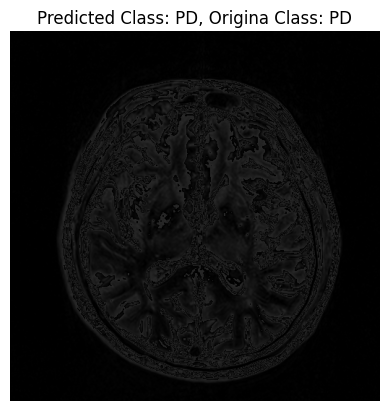

In [34]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import pydicom
from PIL import Image

# Assuming the previous functions and models are already defined and loaded
# Load your model
with open('finalized_model.pkl', 'rb') as file:
    model = pickle.load(file)

def dicom_to_png(input_dir):
    try:
        # Load all DICOM files that end with .dcm
        dicoms = [pydicom.dcmread(os.path.join(input_dir, f)) for f in os.listdir(input_dir) if f.endswith('.dcm')]
        
        # Sort DICOMs by Instance Number
        dicoms.sort(key=lambda x: int(x.InstanceNumber))
        
        # Select the middle DICOM file
        if not dicoms:
            print(f"No DICOM files found in {input_dir}")
            return None
        middle_index = len(dicoms) // 2
        middle_dicom = dicoms[middle_index]

        # Convert pixel data to a NumPy array
        pixel_array = middle_dicom.pixel_array

        # Normalize and convert to uint8
        pixel_array = ((pixel_array - np.min(pixel_array)) * 255) / (np.max(pixel_array) - np.min(pixel_array))
        pixel_array = pixel_array.astype(np.uint8)

        # Convert to PIL Image and return
        image = Image.fromarray(pixel_array)
        return image
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


# Function to process a single image
def process_and_predict(dicom_path,original_Class):
    # Load image
    image = dicom_to_png(dicom_path)
    if image is None:
        return "Image not found or unable to read."
    image = np.array(image)
    if len(image.shape) == 2:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        image_rgb = image

    # Preprocess the image (as per your preprocessing function)
    preprocessed = wavelet_preprocess(image)  # Example preprocessing function
    resized = resize_image(preprocessed, (256, 256))  # Resizing to the input size used during training

    # Extract features
    intensity_features = extract_intensity_features(resized)
    texture_features = extract_texture_features(resized)
    lbp_features = extract_lbp_features(resized)
    features = np.array(intensity_features + texture_features + lbp_features).reshape(1, -1)

    # Feature selection (Apply the same selection indices obtained during training)
    # Load feature indices if saved or ensure they are available in the environment
    selected_indices = np.load('imp_features.npy')  # Load indices if saved
    selected_features = features[:, selected_indices]

    # Predict the class
    prediction = model.predict(selected_features)
    class_name = "PD" if prediction[0] == 0 else "Control"
    
    plt.imshow(image_rgb)
    plt.title(f'Predicted Class: {class_name}, Origina Class: {original_Class}')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
    return class_name

# Example usage
image_path = r"C:\Users\dhanu\Downloads\PD_Test1\PPMI\3616\AX_PD_+_T2\2011-09-26_11_22_17.0\I260397"
original_Class = 'PD'
prediction = process_and_predict(image_path,original_Class)
